## Capstone Project ELSA

## load in packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, brier_score_loss, precision_recall_curve, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [25]:
# Poster colour palette
NAVY = "#174273"       # headings, key lines
PALE_BLUE = "#D1D9E3"  # panel background
CHARCOAL = "#39464D"   # body text on white
WHITE = "#FFFFFF"

## Extract Help dataframe

In [2]:
file_path = "../data/wave_10_elsa_data_eul_v4.tab"
elsa = pd.read_csv(file_path, sep="\t", low_memory=False)
elsa.head()

,idauniq,idahhw10,mode,perid,corepartner,cohort,wavejoined,w10indout,w10hhout,w10scout,...,w10nssec8,w10nssec5,w10nssec3,w10soc2000r,w10sic2003r,gor,w10w1lwgt,w10w4lwgt,w10xwgt,w10scwt
0,100012,106459,2,4,0,1,1,11,110,1,...,-3,-3,-3,-3,-3,E12000003,,,,
1,100023,105225,2,3,0,1,1,11,110,1,...,-3,-3,-3,-3,-3,E12000001,,,,
2,100025,113214,2,2,0,1,1,11,110,2,...,-3,-3,-3,-3,-3,E12000009,,,,
3,100026,107031,2,4,0,1,1,11,110,1,...,-3,-3,-3,-3,-3,E12000006,,,,
4,100029,102261,2,4,0,1,1,11,110,2,...,-3,-3,-3,-3,-3,E12000003,,,,


In [3]:
# Outcome: received any help
neg_codes_catk = [-1, -8, -9]

elsa["catno"] = (
    pd.to_numeric(elsa["catno"], errors="coerce")
      .replace(neg_codes_catk, np.nan)
)

elsa["received_help_any"] = np.where(
    elsa["catno"].isna(),
    np.nan,                 # preserve non-response
    (elsa["catno"] > 0).astype(int)
)

y = elsa["received_help_any"]

## Predictor variables

In [4]:
# keep only columns that exist - extra check
def present(cols):
    return [c for c in cols if c in elsa.columns]

# create copy of dataframe
x_df = elsa.copy()

# Physical activity
activity_freq_vars = present(["heacta", "heactb", "heactc"])   # ordinal 1–4
activity_binary_vars = present(["cahpsex", "scorgsp"])         # binary 0/1


# Mobility
mobility_task_vars = present(["hemobwa", "hemobch", "hemobst", "hemobre", "hemobpu", "hemobli"])

# Health
health_status_vars = present(["hehelf"])                      # ordinal 1–5
health_binary_vars = present(["hepain", "heill", "helim"])     # 1/2
pain_severity_vars = present(["hepaa"])                       # ordinal 

# Chronic conditions (1=yes, 2=no)
chronic_dx_vars = present([
    "heeveras", "heeverar", "heeveros",
    "heeverca", "heevercl", "heeverpd",
    "heeverdm", "heeverms"
])

# Social contact 
social_vars = present(["scchdg","scchdh","scfamg","scfamh","scfrdg","scfrdh"])

# Demographics
demo_raw = present(["indobyr","indsex","dhwork","couple","dimarr"])

# Education (very high missingness)
edu_vars = present(["fqaqua","fqquadeg","fqquaale","fqquagca"])


# Recode rules


# Replace special negatives
neg_codes = [-1, -2, -3, -8, -9]
x_df = x_df.replace(neg_codes, np.nan)

# Health binary vars: often 1=yes, 2=no 
for v in health_binary_vars:
    vals = set(pd.Series(x_df[v].dropna().unique()).astype(float))
    if vals.issubset({1.0, 2.0}):
        x_df[v] = x_df[v].replace({1: 1, 2: 0})

# Chronic dx: 1=yes, 2=no → 1/0
for v in chronic_dx_vars:
    vals = set(pd.Series(x_df[v].dropna().unique()).astype(float))
    if vals.issubset({1.0, 2.0}):
        x_df[v] = x_df[v].replace({1: 1, 2: 0})

# Multimorbidity count
if chronic_dx_vars:
    x_df["chronic_count"] = x_df[chronic_dx_vars].sum(axis=1, min_count=1)


# Mobility summary
if mobility_task_vars:
    x_df["mobility_count"] = x_df[mobility_task_vars].sum(axis=1, min_count=1)

# Demographics derived
if "indobyr" in x_df.columns:
    x_df["age"] = np.where(
        x_df["indobyr"] == -7,
        90,  # or 91–95; see note below
        2020 - pd.to_numeric(x_df["indobyr"], errors="coerce")
    )

x_df["age_topcoded_90plus"] = (x_df["indobyr"] == -7).astype(int)


if "indsex" in x_df.columns:
    # 1=Male, 2=Female → female=1
    x_df["female"] = x_df["indsex"].replace({1: 0, 2: 1})

if "dhwork" in x_df.columns:
    # 1=Yes, 2=No → employed=1
    vals = set(pd.Series(x_df["dhwork"].dropna().unique()).astype(float))
    if vals.issubset({1.0, 2.0}):
        x_df["employed"] = x_df["dhwork"].replace({1: 1, 2: 0})

if "couple" in x_df.columns:
    x_df["partnered"] = x_df["couple"].replace({
        1: 1,  # married
        2: 1,  # cohabit
        3: 0   # neither
    })

# Education recoding
if "fqaqua" in x_df.columns:
    x_df["fqaqua"] = x_df["fqaqua"].replace({1: 1, 2: 0})


# Missingness indicators (informative non-response)
if "scorgsp" in x_df.columns:
    x_df["scorgsp_missing"] = x_df["scorgsp"].isna().astype(int)

if "hepaa" in x_df.columns:  # highly missing variable
    x_df["hepaa_missing"] = x_df["hepaa"].isna().astype(int)

if social_vars:
    x_df["social_contact_all_missing"] = (
        x_df[social_vars].isna().all(axis=1).astype(int)
    )

if edu_vars:
    x_df["education_all_missing"] = x_df[edu_vars].isna().all(axis=1).astype(int)

if "hepaa" in x_df.columns and "hepain" in x_df.columns:
    x_df["pain_severity_0to3"] = np.where(x_df["hepain"] == 0, 0,x_df["hepaa"])

# Education summary: any qualification mentioned/yes (keeps NA if all education missing)
if edu_vars:
    x_df["has_qualification"] = x_df[edu_vars].max(axis=1, skipna=True)

# -----------------------------
# Final predictor list (only what exists)
# -----------------------------
predictors = (
    activity_freq_vars
    + activity_binary_vars
    + (["mobility_count"] if "mobility_count" in x_df.columns else [])
    + health_status_vars
    + health_binary_vars
    # Pain: keep filled/derived version + missing flag; drop raw hepaa from predictors
    + (["pain_severity_0to3"] if "pain_severity_0to3" in x_df.columns else [])
    + (["hepaa_missing"] if "hepaa_missing" in x_df.columns else [])
    + (["chronic_count"] if "chronic_count" in x_df.columns else [])
    + social_vars
    + [c for c in ["age", "female", "employed", "partnered"] if c in x_df.columns]
    # Education: keep summary + block missingness; drop raw edu vars
    + (["has_qualification"] if "has_qualification" in x_df.columns else [])
    + (["education_all_missing"] if "education_all_missing" in x_df.columns else [])
    # Missingness / top-coding indicators
    + (["scorgsp_missing"] if "scorgsp_missing" in x_df.columns else [])
    + (["social_contact_all_missing"] if "social_contact_all_missing" in x_df.columns else [])
    + (["age_topcoded_90plus"] if "age_topcoded_90plus" in x_df.columns else [])
)


X = x_df[predictors].copy()
X = X.loc[:, X.nunique(dropna=False) > 1]

print("Predictors used:", len(predictors))
X.head()

Predictors used: 28


,heacta,heactb,heactc,cahpsex,scorgsp,mobility_count,hehelf,hepain,heill,helim,...,scfrdh,age,female,employed,partnered,has_qualification,education_all_missing,scorgsp_missing,social_contact_all_missing,age_topcoded_90plus
0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,...,4.0,73,0,0.0,1,NaN,1,0,0,0
1,4.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,NaN,...,3.0,61,1,0.0,1,NaN,1,0,0,0
2,2.0,1.0,1.0,0.0,NaN,0.0,3.0,0.0,0.0,NaN,...,NaN,90,0,0.0,1,NaN,1,1,1,1
3,4.0,4.0,4.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,...,2.0,78,0,0.0,1,NaN,1,0,0,0
4,4.0,1.0,1.0,0.0,NaN,1.0,4.0,0.0,1.0,0.0,...,NaN,70,1,0.0,1,NaN,1,1,1,0


In [5]:
X.isna().mean().sort_values(ascending=False)

has_qualification             0.938200
helim                         0.469891
scchdh                        0.327579
scchdg                        0.327316
scfamg                        0.221900
scfrdh                        0.221768
scfamh                        0.221637
scfrdg                        0.216102
scorgsp                       0.178943
pain_severity_0to3            0.050863
hepain                        0.050336
hehelf                        0.050072
employed                      0.003953
heactb                        0.000395
heacta                        0.000395
cahpsex                       0.000395
heactc                        0.000395
chronic_count                 0.000264
heill                         0.000264
mobility_count                0.000264
hepaa_missing                 0.000000
age                           0.000000
female                        0.000000
partnered                     0.000000
education_all_missing         0.000000
scorgsp_missing          

### Train test split

In [6]:
# Drop rows with missing outcome
mask = y.notna()
X_model = X.loc[mask].copy()
y_model = y.loc[mask].copy()

# Train / test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_model,
    y_model,
    test_size=0.25,
    stratify=y_model,
    random_state=8
)

### Visualize missingness

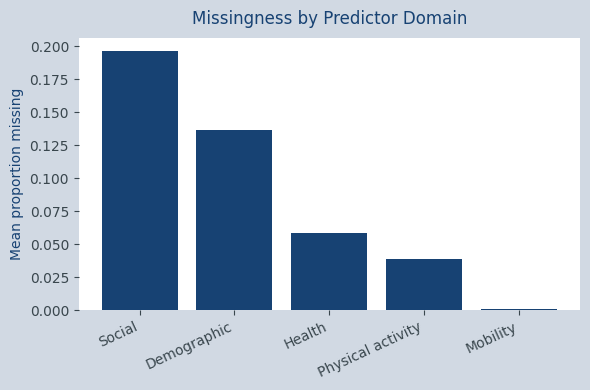

In [27]:
# Column-level missingness on the modelling dataset (after dropping missing outcome)
col_missing = X_model.isna().mean()

# Define domains using *actual model columns*
missing_groups = {
    "Physical activity": activity_freq_vars + activity_binary_vars,
    "Mobility": (["mobility_count"] if "mobility_count" in X_model.columns else []),
    "Health": (
        health_status_vars
        + health_binary_vars
        + (["chronic_count"] if "chronic_count" in X_model.columns else [])
        + (["pain_severity_0to3"] if "pain_severity_0to3" in X_model.columns else [])
        + (["hepaa_missing"] if "hepaa_missing" in X_model.columns else [])
    ),
    "Social": (
        social_vars
        + (["scorgsp_missing"] if "scorgsp_missing" in X_model.columns else [])
        + (["social_contact_all_missing"] if "social_contact_all_missing" in X_model.columns else [])
    ),
    "Demographic": [
        c for c in [
            "age", "female", "employed", "partnered",
            "age_topcoded_90plus",
            "has_qualification", "education_all_missing"
        ]
        if c in X_model.columns
    ],
}

# Compute mean missingness per group
group_missing = {}
for g, cols in missing_groups.items():
    cols_present = [c for c in cols if c in col_missing.index]
    group_missing[g] = col_missing[cols_present].mean() if cols_present else np.nan

group_missing_s = pd.Series(group_missing).dropna().sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor(PALE_BLUE)  # outside plot (poster background)
ax.set_facecolor(WHITE)             # inside plot (data area)


ax.bar(
    group_missing_s.index,
    group_missing_s.values,
    color=NAVY
)

ax.set_ylabel("Mean proportion missing", color=NAVY)
ax.set_title("Missingness by Predictor Domain", color=NAVY, pad=10)

ax.tick_params(axis="x", colors=CHARCOAL)
ax.tick_params(axis="y", colors=CHARCOAL)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


### Class imbalance

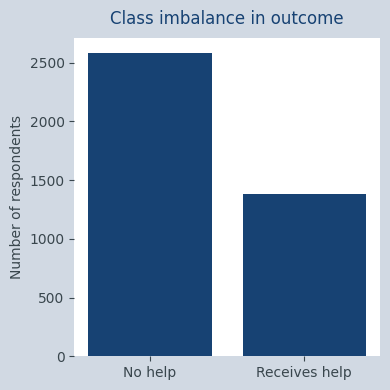

In [37]:
# Outcome distribution
class_counts = y_model.value_counts().sort_index()
labels = ["No help", "Receives help"]

fig, ax = plt.subplots(figsize=(4, 4))
fig.patch.set_facecolor(PALE_BLUE)
ax.set_facecolor(WHITE)

ax.bar(labels, class_counts.values, color=NAVY)

ax.set_title("Class imbalance in outcome", color=NAVY, pad=10)
ax.set_ylabel("Number of respondents", color=CHARCOAL)
ax.tick_params(axis="x", colors=CHARCOAL)
ax.tick_params(axis="y", colors=CHARCOAL)

# Clean poster look
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [38]:
# Exploratory check: mobility vs probability of receiving help
(
    X_model.assign(received_help=y_model)
    .groupby("mobility_count")["received_help"]
    .mean()
)


mobility_count
0.0    0.214844
1.0    0.116599
2.0    0.254007
3.0    0.461078
4.0    0.643875
5.0    0.797386
6.0    0.900826
Name: received_help, dtype: float64

<Axes: title={'center': 'Exploratory: Mobility vs Receipt of Help'}, xlabel='mobility_count'>

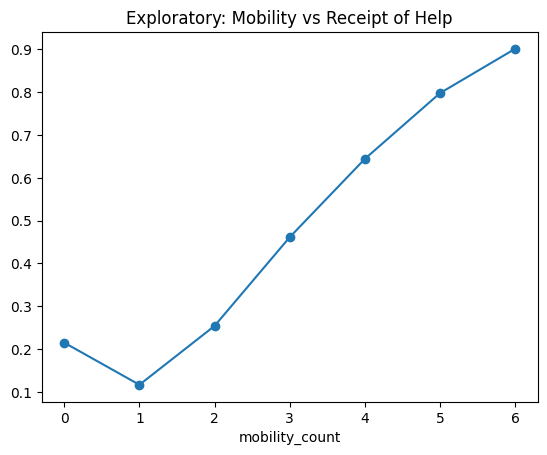

In [ ]:
(
    X_model.assign(received_help=y_model)
    .groupby("mobility_count")["received_help"]
    .mean()
    .plot(marker="o", title="Exploratory: Mobility vs Receipt of Help")
)



In [40]:
(
    X_model.assign(received_help=y_model)
    .groupby("hehelf")["received_help"]
    .mean()
)


hehelf
1.0    0.111111
2.0    0.142857
3.0    0.244974
4.0    0.418819
5.0    0.707885
Name: received_help, dtype: float64

### Modelling

In [7]:
pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            random_state=8,
            class_weight="balanced",
            n_jobs=-1,
            bootstrap=True,
            oob_score=True
        ))
    ]
)

In [8]:
param_grid = {
    "rf__n_estimators": [400, 800, 1200],
    "rf__max_depth": [None, 12, 18, 24],
    "rf__min_samples_leaf": [5, 10, 20, 40],
    "rf__min_samples_split": [10, 20, 50, 100],
    "rf__max_features": ["sqrt", 0.3, 0.5, 0.7],
    "rf__bootstrap": [True],
    "rf__max_samples": [0.6, 0.8, None]
}

In [9]:
search = RandomizedSearchCV(
    pipe,
    param_grid,
    n_iter=80,
    scoring="roc_auc",
    cv=5,
    random_state=8,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_rf = search.best_estimator_
imputer = best_rf.named_steps["imputer"]
X_train_imp = imputer.transform(X_train)

In [10]:
print("Best params:", search.best_params_)

print(
    "Train ROC AUC:",
    roc_auc_score(y_train, best_rf.predict_proba(X_train)[:, 1])
)

print(
    "Test ROC AUC:",
    roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
)


Best params: {'rf__n_estimators': 400, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 10, 'rf__max_samples': 0.8, 'rf__max_features': 'sqrt', 'rf__max_depth': 18, 'rf__bootstrap': True}
Train ROC AUC: 0.90166568089902
Test ROC AUC: 0.8368812492978318


In [11]:
# Decision tree for visual
tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=8
)

tree.fit(X_train_imp, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=50, random_state=8)

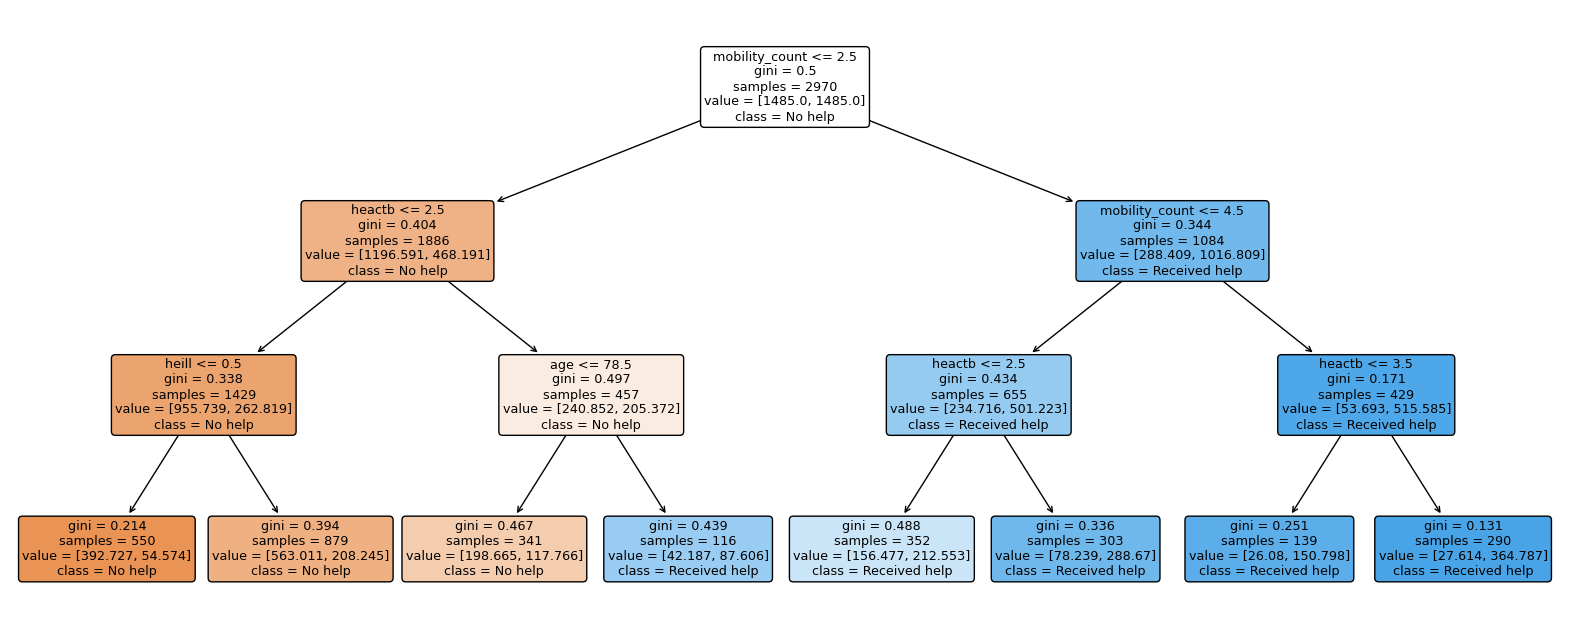

In [12]:
plt.figure(figsize=(20, 8))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=["No help", "Received help"],
    filled=True,
    rounded=True
)
plt.show()

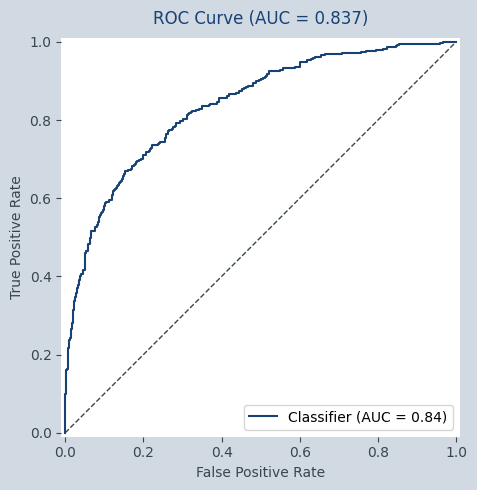

In [28]:
# Probabilities from the tuned pipeline
y_prob = best_rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

fig, ax = plt.subplots(figsize=(6, 5))
fig.patch.set_facecolor(PALE_BLUE)   # blends into poster
ax.set_facecolor(WHITE)              # plot area

RocCurveDisplay.from_predictions(
    y_test,
    y_prob,
    ax=ax,
    color=NAVY
)

# Diagonal reference
ax.plot([0, 1], [0, 1], linestyle="--", color=CHARCOAL, linewidth=1)

ax.set_title(f"ROC Curve (AUC = {auc:.3f})", color=NAVY, pad=10)
ax.set_xlabel("False Positive Rate", color=CHARCOAL)
ax.set_ylabel("True Positive Rate", color=CHARCOAL)

ax.tick_params(colors=CHARCOAL)

# Clean poster look
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Permutation importance on the TEST set (pipeline handles imputation)
perm = permutation_importance(
    best_rf,  
    X_test,
    y_test,
    n_repeats=10,
    random_state=8,
    n_jobs=-1,
    scoring="roc_auc"
)

perm_df = pd.Series(
    perm.importances_mean,
    index=X_test.columns
).sort_values(ascending=False)

groups = {
    "Physical activity": activity_freq_vars + activity_binary_vars,

    "Mobility": (["mobility_count"] if "mobility_count" in X_test.columns else []),

    "Health": (
        health_status_vars
        + health_binary_vars
        + (["chronic_count"] if "chronic_count" in X_test.columns else [])
        + (["pain_severity_0to3"] if "pain_severity_0to3" in X_test.columns else [])
        + (["hepaa_missing"] if "hepaa_missing" in X_test.columns else [])
    ),

    "Social": (
        social_vars
        + (["scorgsp_missing"] if "scorgsp_missing" in X_test.columns else [])
        + (["social_contact_all_missing"] if "social_contact_all_missing" in X_test.columns else [])
    ),

    "Demographic": [
        c for c in [
            "age", "female", "employed", "partnered",
            "age_topcoded_90plus",
            "has_qualification", "education_all_missing"
        ]
        if c in X_test.columns
    ],
}


grouped_importance = {}

for g, vars_ in groups.items():
    vars_present = [v for v in vars_ if v in perm_df.index]
    grouped_importance[g] = perm_df[vars_present].sum() if vars_present else 0.0

grouped_imp_s = pd.Series(grouped_importance).sort_values(ascending=False)
grouped_imp_s


pd.Series(grouped_importance).sort_values(ascending=False)


Mobility             0.080783
Health               0.037668
Physical activity    0.019379
Demographic          0.017461
Social               0.007481
dtype: float64

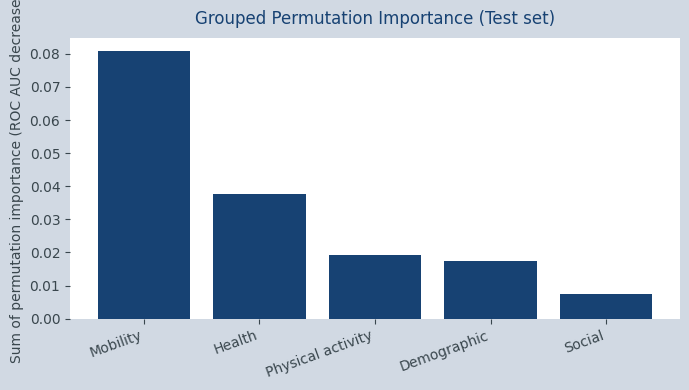

In [34]:
fig, ax = plt.subplots(figsize=(7, 4))
fig.patch.set_facecolor(PALE_BLUE)  # outside plot
ax.set_facecolor(WHITE)             # inside plot

ax.bar(grouped_imp_s.index, grouped_imp_s.values, color=NAVY)

ax.set_title("Grouped Permutation Importance (Test set)", color=NAVY, pad=10)
ax.set_ylabel("Sum of permutation importance (ROC AUC decrease)", color=CHARCOAL)
ax.tick_params(axis="x", colors=CHARCOAL)
ax.tick_params(axis="y", colors=CHARCOAL)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


ROC AUC: 0.837

Classification report (threshold = 0.5):
              precision    recall  f1-score   support

         0.0      0.824     0.850     0.837       645
         1.0      0.702     0.661     0.681       345

    accuracy                          0.784       990
   macro avg      0.763     0.755     0.759       990
weighted avg      0.781     0.784     0.782       990



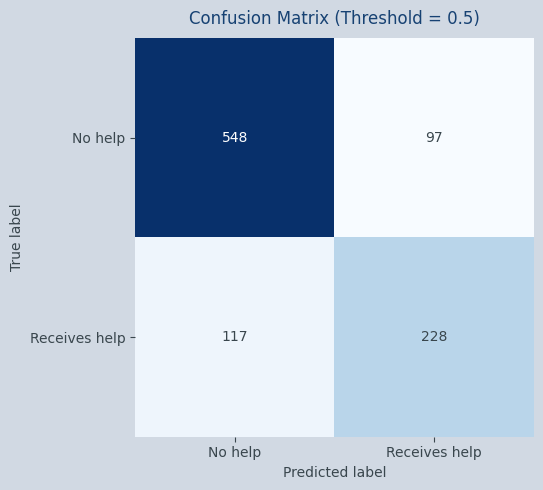

In [ ]:
# Predict probabilities and classes
y_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# ROC AUC
auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {auc:.3f}")

# Classification report
print("\nClassification report (threshold = 0.5):")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 5))
fig.patch.set_facecolor(PALE_BLUE)   
ax.set_facecolor(WHITE)            

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No help", "Receives help"]
)

disp.plot(ax=ax, cmap="Blues", colorbar=False)

ax.set_title("Confusion Matrix (Threshold = 0.5)", color=NAVY, pad=10)
ax.set_xlabel("Predicted label", color=CHARCOAL)
ax.set_ylabel("True label", color=CHARCOAL)
ax.tick_params(colors=CHARCOAL)

# Make the numbers readable on dark cells
for t in ax.texts:
    t.set_color(WHITE if t.get_text().strip() and float(t.get_text()) > cm.max() * 0.5 else CHARCOAL)

# Clean poster look
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [15]:
# Predicted probabilities on test set
probs = best_rf.predict_proba(X_test)[:, 1]

# Precision–recall trade-off
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# F1 score across thresholds
f1 = 2 * precision * recall / (precision + recall)

best_idx = f1.argmax()

print("Optimal threshold (max F1):", thresholds[best_idx])
print("Precision at optimal threshold:", precision[best_idx])
print("Recall at optimal threshold:", recall[best_idx])


Optimal threshold (max F1): 0.4975342793160803
Precision at optimal threshold: 0.7021276595744681
Recall at optimal threshold: 0.6695652173913044


In [16]:
opt_thresh = thresholds[best_idx]
y_pred_opt = (probs >= opt_thresh).astype(int)

print(classification_report(y_test, y_pred_opt))


              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       645
         1.0       0.70      0.67      0.69       345

    accuracy                           0.79       990
   macro avg       0.76      0.76      0.76       990
weighted avg       0.78      0.79      0.78       990



Brier score: 0.1552


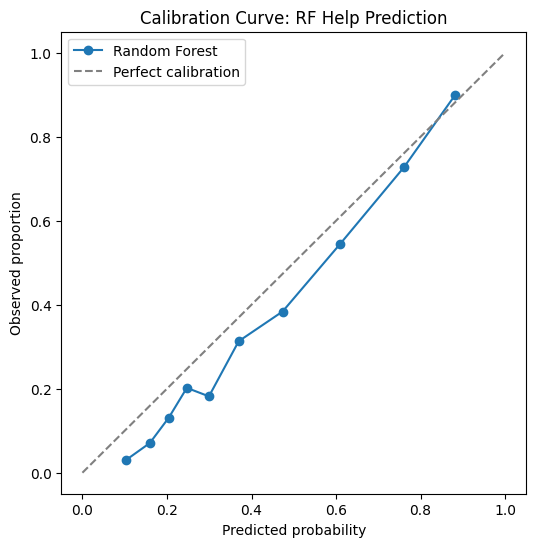

In [17]:
# Calibration curve
prob_true, prob_pred = calibration_curve(
    y_test,
    y_prob,
    n_bins=10,
    strategy="quantile"
)

# Brier score
brier = brier_score_loss(y_test, y_prob)
print(f"Brier score: {brier:.4f}")

# Plot calibration
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")

plt.xlabel("Predicted probability")
plt.ylabel("Observed proportion")
plt.title("Calibration Curve: RF Help Prediction")
plt.legend()
plt.show()


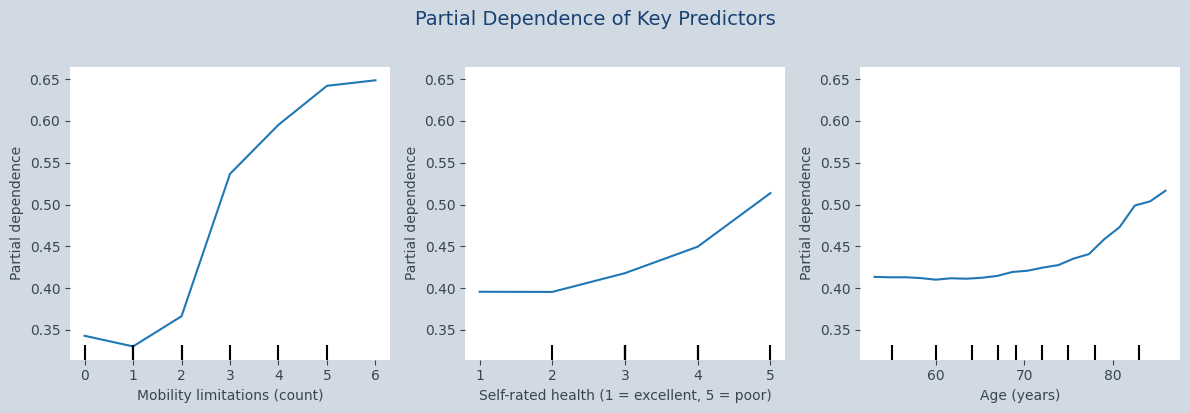

In [35]:
features_pdp = ["mobility_count", "hehelf", "age"]

# One subplot per feature
fig, axes = plt.subplots(
    1, len(features_pdp),
    figsize=(12, 4),
    sharey=False
)

# Figure background 
fig.patch.set_facecolor(PALE_BLUE)

# PDP
PartialDependenceDisplay.from_estimator(
    best_rf,          # full pipeline
    X_train,          
    features=features_pdp,
    kind="average",
    grid_resolution=20,
    ax=axes
)

# Style each subplot
for ax in axes:
    ax.set_facecolor(WHITE)
    ax.tick_params(colors=CHARCOAL, labelsize=10)
    ax.xaxis.label.set_color(CHARCOAL)
    ax.yaxis.label.set_color(CHARCOAL)

    # Clean poster look
    for spine in ax.spines.values():
        spine.set_visible(False)

# Title (
fig.suptitle(
    "Partial Dependence of Key Predictors",
    color=NAVY,
    fontsize=14,
    y=1.02
)

axes[0].set_xlabel("Mobility limitations (count)", color=CHARCOAL)
axes[1].set_xlabel("Self-rated health (1 = excellent, 5 = poor)", color=CHARCOAL)
axes[2].set_xlabel("Age (years)", color=CHARCOAL)

plt.tight_layout()
plt.show()
